In [1]:
#import necessary python libraries
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import math
from JSON_to_DF import JSON_to_DataFrame
%matplotlib notebook

In [58]:
#Load data into a pandas dataframe for easier manipulation
df = JSON_to_DataFrame("../../../OSN_data/JSON_data/SN2011fe.json")



In [59]:
#Define the Kapernka model for supernovae light curves
def Kapernka(t, A, B, t_0, t_1, Tfall, Trise):
	first = A * (1 + (B * (t - t_1)*(t - t_1)))
	var = -(t - t_0)
	second = np.exp(var / Tfall)
	third = 1 + np.exp(var / Trise)
	return first * (second / third)

In [60]:
def Newling(t, A, phi, sig, k, psi):
    tau = (k * sig) + phi
    psi_t = NaN
    if( t )
    
    
    first = (A * ((t - phi) / sig)*k)
    second = (np.exp(- (t - phi) / sigma))*(k*-k)*(np.exp(k))
    return (first * second) + 

SyntaxError: invalid syntax (<ipython-input-60-4c49748fbb41>, line 4)

In [61]:
#Create dictionaries to hold priors for model
priors = {
            'R' : [50, 20, 20, 50, 50, 50],
            'g' : [40,20,10,40,1,100],
            'I' : [100, 20, 20, 50, 50, 50]
          }
param_bounds = ([10*-5,10*-5,0,0,0,0], [1000,100,100,100,100,100])

In [62]:
#Define conversions for magnitude to flux, and mag error to flux errof
def mag_to_flux(mag):
    
    return 10**(-2*mag / 5) 

def mag_err_to_flux_err(mag, err, flux):
        
        mag_max = mag + err
        flux_max = mag_to_flux(mag_max)
        flux_error = flux_max - flux
        return flux_error

In [63]:
#convert magnitude to flux, and add that column to dataframe
df['flux'] = df.magnitude.apply(mag_to_flux)

#convert given errors to flux errors, and add that column to data frame
df['flux_error'] = df.apply(lambda row: mag_err_to_flux_err(row['magnitude'], row['e_magnitude'], row['flux']), axis=1)
df['flux_upper_error'] = df.apply(lambda row: mag_err_to_flux_err(row['magnitude'], row['e_upper_magnitude'], row['flux']), axis=1)
df['flux_lower_error'] = df.apply(lambda row: mag_err_to_flux_err(row['magnitude'], row['e_lower_magnitude'], row['flux']), axis=1)

#splice dataframe into three partitions according to band filter 
R_bools = (df.band == 'R')
R_data = df[R_bools]

I_bools = (df.band == 'I')
I_data = df[I_bools]

g_bools = (df.band == 'g')
g_data = df[g_bools]



In [64]:
#get ride of outlier data point in g-band
g_data = g_data.drop(g_data.index[0])


In [65]:


#find minimum start time to shift.
start_time = min(R_data.time.iloc[0], I_data.time.iloc[0], g_data.time.iloc[0])

R_data.iloc[:,0] = R_data.time - start_time
g_data.iloc[:,0] = g_data.time - start_time
I_data.iloc[:,0] = I_data.time - start_time


In [66]:
#Find best fit coefficients for the Kapernka model
fitCoeffs_I, Covars_I = curve_fit(Kapernka, I_data.time.values, I_data.flux.values , priors['I'], bounds=param_bounds)
fitCoeffs_g, Covars_g = curve_fit(Kapernka, g_data.time.values, g_data.flux.values, priors['g'], bounds=param_bounds)
fitCoeffs_R, Covars_R = curve_fit(Kapernka, R_data.time.values, R_data.flux.values , priors['R'], bounds=param_bounds)


In [67]:
#create array of evenly spaced time intervals
bft_I = np.linspace(I_data.time.iloc[0], I_data.time.iloc[-1], 500)
bft_g = np.linspace(g_data.time.iloc[0], g_data.time.iloc[-1], 500)
bft_R = np.linspace(R_data.time.iloc[0], R_data.time.iloc[-1], 500)

In [68]:
bestfit_flux_I = Kapernka(bft_I, fitCoeffs_I[0], fitCoeffs_I[1], fitCoeffs_I[2], fitCoeffs_I[3], fitCoeffs_I[4],fitCoeffs_I[5])

bestfit_flux_g = Kapernka(bft_g, fitCoeffs_g[0], fitCoeffs_g[1], fitCoeffs_g[2], fitCoeffs_g[3], fitCoeffs_g[4],fitCoeffs_g[5])

bestfit_flux_R = Kapernka(bft_R, fitCoeffs_R[0], fitCoeffs_R[1], fitCoeffs_R[2], fitCoeffs_R[3], fitCoeffs_R[4],fitCoeffs_R[5])

<IPython.core.display.Javascript object>


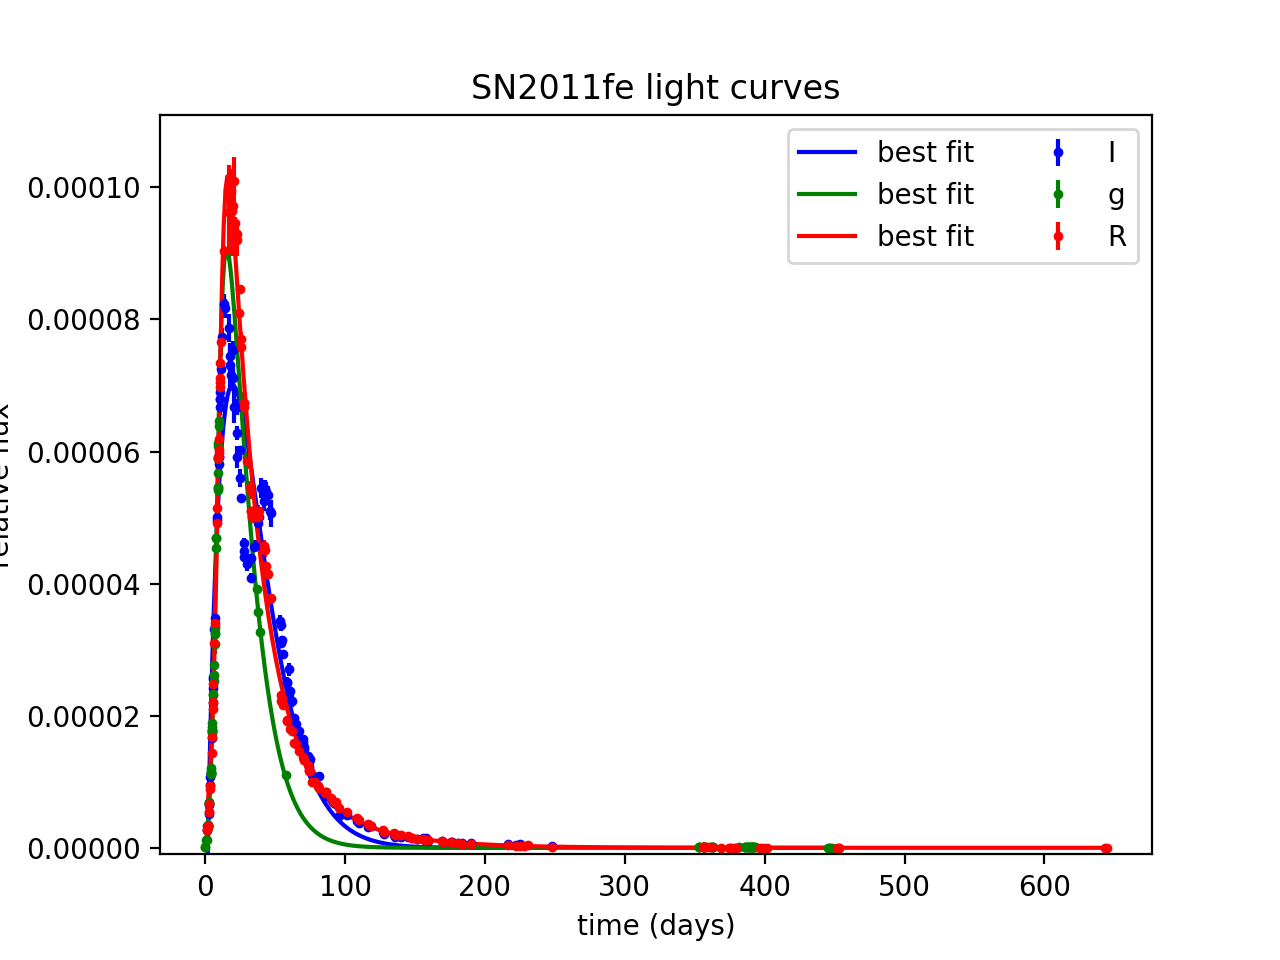

In [69]:
plt.errorbar(I_data.time.values, I_data.flux.values, yerr=I_data.flux_error.values, color='blue', label= 'I', fmt = 'o', markersize = 2.5)
plt.errorbar(g_data.time.values, g_data.flux.values, yerr=g_data.flux_upper_error.values, color='green', label= 'g', fmt = 'o', markersize = 2.5)
plt.errorbar(R_data.time.values, R_data.flux.values, yerr=R_data.flux_error.values, color='red', label= 'R', fmt = 'o', markersize = 2.5)
plt.plot(bft_I, bestfit_flux_I, color = 'blue', label ='best fit')
plt.plot(bft_g, bestfit_flux_g, color = 'green', label = 'best fit')
plt.plot(bft_R, bestfit_flux_R, color = 'red', label = 'best fit')
ax = plt.gca()
ax.set_ylim([-0.000001, np.amax(R_data.flux.values) + .00001])
plt.legend(ncol=2)
plt.title('SN2011fe light curves')
plt.xlabel('time (days)')
plt.ylabel('relative flux')
plt.show()